# Projeto
A rede de academias Model Fitness está desenvolvendo uma estratégia de interação com o cliente baseados em dados analíticos.

Um dos problemas mais comuns que academias e outros serviços enfrentam é a rotatividade de clientes. Como você sabe se um cliente não está mais com você? Você pode calcular a rotatividade baseado nas pessoas que se livram das suas contas ou não renovam seus contratos. No entanto, às vezes não é óbvio que um cliente saiu: eles podem sair de fininho.

Indicadores de rotatividade varia de área para área. Se um usuário compra de uma loja online raramente mas regularmente, você não pode dizer que é um fujão. Mas se por duas semanas eles não abriam o canal que é atualizado diariamente, essa é uma razão para se preocupar: seu seguidor pode ter ficado aborrecido e deixado você.

Para uma academia, faz sentido dizer que os clientes saíram se eles não aparecem há um mês. É claro, é possível que eles estejam em Cancun e virão tornar a frequentar quando retornarem, mas esse não é um caso comum. Normalmente, se um cliente ingressa, vem algumas vezes, depois desaparece, ele provavelmente não voltará.

Em vez de lutar com a rotatividade, Model Fitness digitalizou uma parte dos perfis dos clientes. Sua tarefa é analisá-los e vir com uma estratégia de retenção de clientes.

Você deve:

- Aprender a predizer a probabilidade de rotatividade (para o mês seguinte) para cada cliente
- Elabore retratos de usuários típicos: selecione os grupos mais marcantes e descreva suas principais características
- Analise os fatores que mais impactam a rotatividade
- Tire conclusões básicas e desenvolva recomendações sobre como melhorar o serviço de clientes:
    - Identifique grupos alvo
    - Sugira medidas para diminuir a rotatividade
    - Descreva qualquer outro padrão que você vir com respeito às interações com clientes

### Instruções para completar o projeto

### <b> Passo 1. Baixar os dados </b>
Model Fitness forneceu a você dados CSV contendo dados sobre rotatividade em um determinado mês e informações sobre o mês anterior. O conjunto de dados inclui os seguintes campos:

- 'Churn'  a rotatividade do mês em questão

- Campos de dados atuais:

    - Dados do mês anterior
    - 'gender'
    - 'Near_Location' — se o cliente morar ou trabalhar na vizinhança onde a academia está localizada
    - 'Partner' — se o usuário for um funcionário de uma companhia parceira (a academia tem empresas parceiras cujos funcionários conseguem descontos; nesses casos, a academia armazena informações sobre clientes de são funcionários)
    - Promo_friends — se o cliente originalmente se inscreveu através de uma oferta "traga um amigo" eles normalmente usam o código de promoção do amigo quando pagam pela primeira filiação)
    - 'Phone' — se o usuário fornece o seu número de telefone
    - 'age' (idade)
    - 'Lifetime' — o tempo (em meses) desde a primeira vez que o cliente veio à academia
- Dados do log de frequência e compras e dados sobre status de filiação atual
    - 'Contract_period' — 1 mês, 3 meses, 6 meses, ou um ano
    - 'Month_to_end_contract' — os meses remanescentes até que o contrato expira
    - 'Group_visits' — se o cliente participa de sessões em grupo
    - 'Avg_class_frequency_total' — frequência média de idas por semana por toda a vida do cliente
    - 'Avg_class_frequency_current_month' — frequência média de visitas por semana durante o mês corrente
    - 'Avg_additional_charges_total' — a quantidade total de dinheiro gasto em outros serviços da academia: café, artigos esportivos, cosméticos, massagem, etc.

In [1]:
#importando as bibliotecas necessárias

import pandas as pd
import numpy as np
import datetime as dt
import scipy.stats as stats

import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from scipy.cluster.hierarchy import linkage, dendrogram

from sklearn.cluster import KMeans
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    accuracy_score, precision_score, recall_score, f1_score, silhouette_score
)
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier, GradientBoostingClassifier, 
)
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score
)


c:\Users\KamilaTiemi\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
#lendo os dados do csv
gym = pd.read_csv('gym_churn_us.csv', sep=',')

#redefinindo o nome das colunas para minusculo
gym.columns = gym.columns.str.lower()

In [3]:
#imprimindo as informações:

gym.head()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [4]:
gym.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   near_location                      4000 non-null   int64  
 2   partner                            4000 non-null   int64  
 3   promo_friends                      4000 non-null   int64  
 4   phone                              4000 non-null   int64  
 5   contract_period                    4000 non-null   int64  
 6   group_visits                       4000 non-null   int64  
 7   age                                4000 non-null   int64  
 8   avg_additional_charges_total       4000 non-null   float64
 9   month_to_end_contract              4000 non-null   float64
 10  lifetime                           4000 non-null   int64  
 11  avg_class_frequency_total          4000 non-null   float

Explorando o conjunto dos dados, podemos perceber que não existem valores ausentes e todos eles foram convertidos para o formato numérico.

### <b> Passo 2. Realize análise exploratória dos dados (AED) </b>

#### Olhe para o conjunto de dados: ele contém alguma característica ausente? Estude a média de valores e desvio padrão (use o método describe()).

In [5]:
gym.describe()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


Nessa análise pudemos perceber alguns pontos:
 - A idade dos clientes é de 18 a 41 anos, sendo a média de 29 anos.
 - Os clientes podem contratar de 1, 6 ou até 12 meses, com a média sendo 4,6 meses.
 - 75% dos clientes assinam contratos de 6 meses, atendendo a 2,5 aulas por mês. 
 - O desvio padrão de 1,05 sugere 
 - O gasto máximo com cobranças adicionais foi de $552 e uma média de $146.

#### Observe a média dos valores médios das características em dois grupos: para aqueles que ficaram (use o método groupby()).

In [6]:
churn = gym.groupby('churn').mean()

churn

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


Alunos que cancelaram, permaneceram por menos de 2 meses (1,7 meses) e seu lifetime foi de apenas 0,99 meses, o que indica que eles mal ficaram o primeiro mês.
A  frequência de presença no mês foi de 1,04 aulas e, apesar do cancelamento, eles gastaram $43 a menos que aqueles que não cancelaram.
Além disso, não canceladores têm um período médio de contrato de 5,74 meses e uma vida útil média de 4,71 meses. Isso reforça ainda mais a constatação de que a maioria dos usuários não permanece na academia por mais de 6 meses, alinhando-se com a percepção anterior de que 75% dos usuários têm uma duração de contrato e vida útil de 6 meses ou menos.

#### Faça histogramas de barra e distribuições de características para aqueles que saíram (rotatividade) e aqueles que ficaram.

In [7]:
columns_churn=['age', 'avg_additional_charges_total', 'month_to_end_contract', 'lifetime',
                 'avg_class_frequency_total', 'avg_class_frequency_current_month', 'partner']

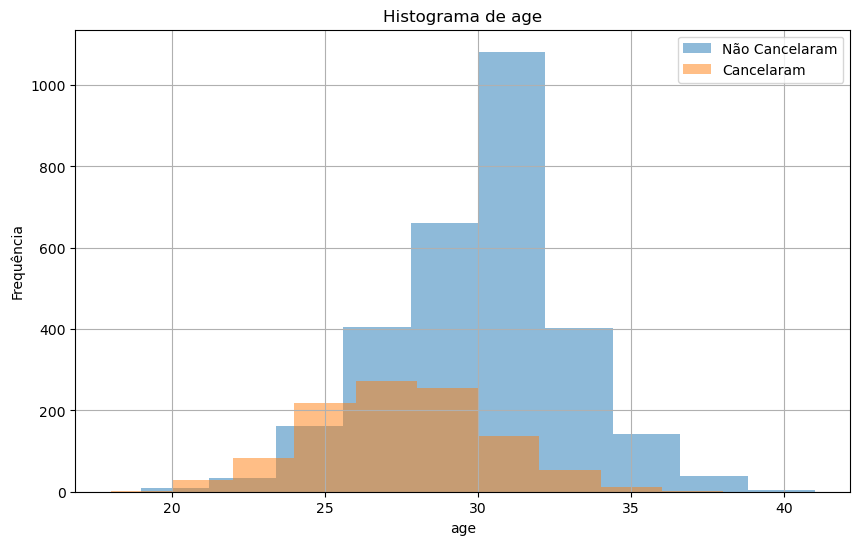

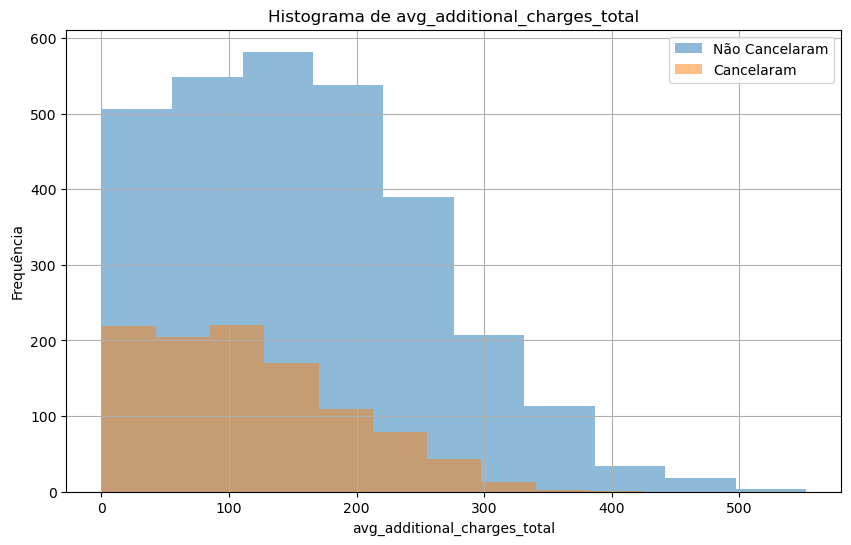

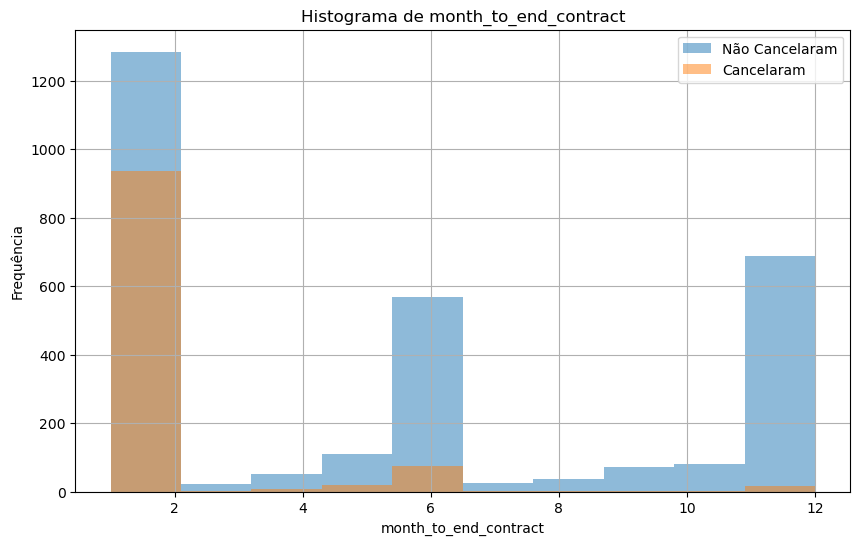

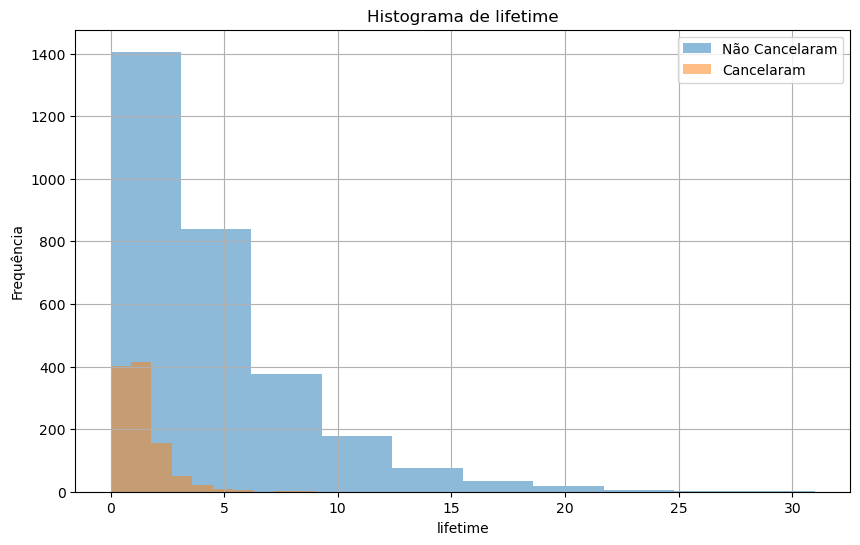

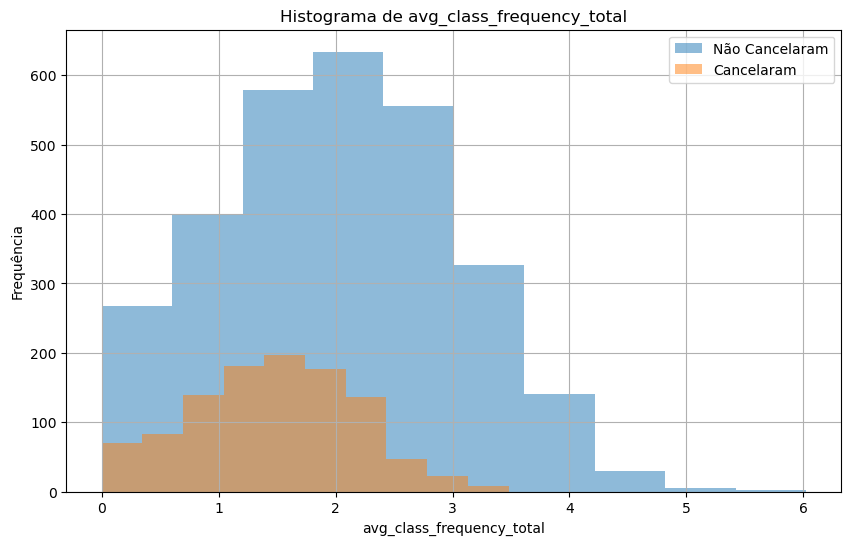

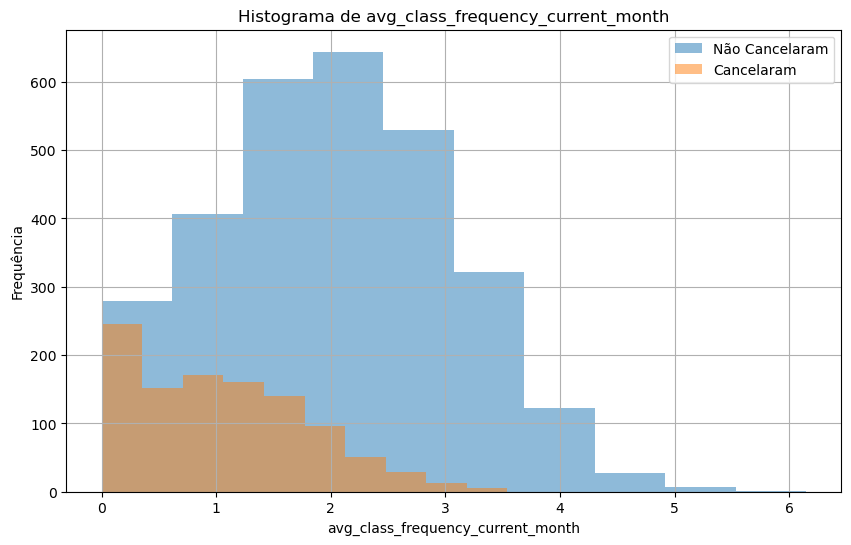

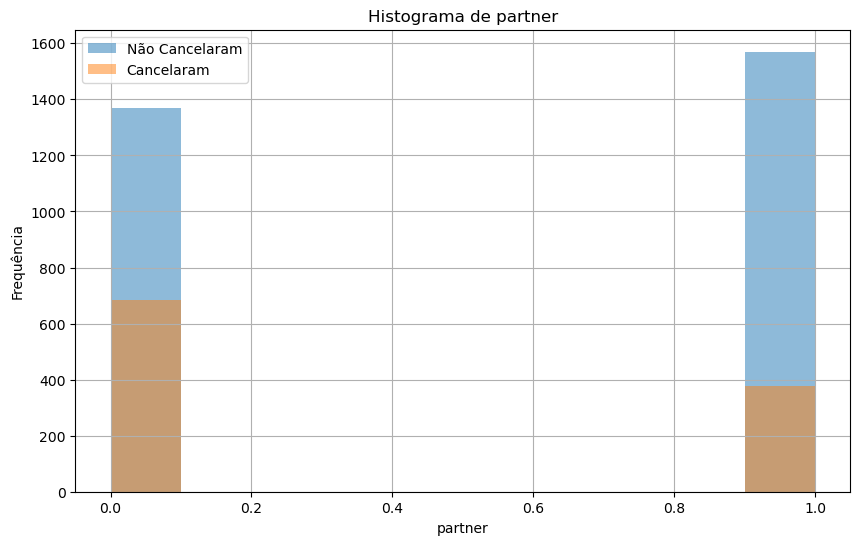

In [8]:
for caracteristica in columns_churn:
    plt.figure(figsize=(10, 6))
    gym[gym['churn'] == 0][caracteristica].hist(alpha=0.5, label='Não Cancelaram')
    gym[gym['churn'] == 1][caracteristica].hist(alpha=0.5, label='Cancelaram')
    plt.legend()
    plt.title(f'Histograma de {caracteristica}')
    plt.xlabel(caracteristica)
    plt.ylabel('Frequência')
    plt.show()

Podemos perceber algumas coisas com os gráficos sobre os clientes que cancelaram:.
1. A idade está concentrada entre 24 a 30 anos, demonstrando que são pessoas mais novas.
2. Eles gastaram até 100 dólares com cobranças extras.
3. A maioria deles ficou entre 0 a 2 meses.
4. O lifetime foi entre 0 a 3 meses.
5. Grande parte frequentou entre 0 a 1 aula
6. Eles não eram funcionários de empresas parceiras

#### Construa a matriz de correlação e a exiba.

<Axes: title={'center': 'Correlação das características'}>

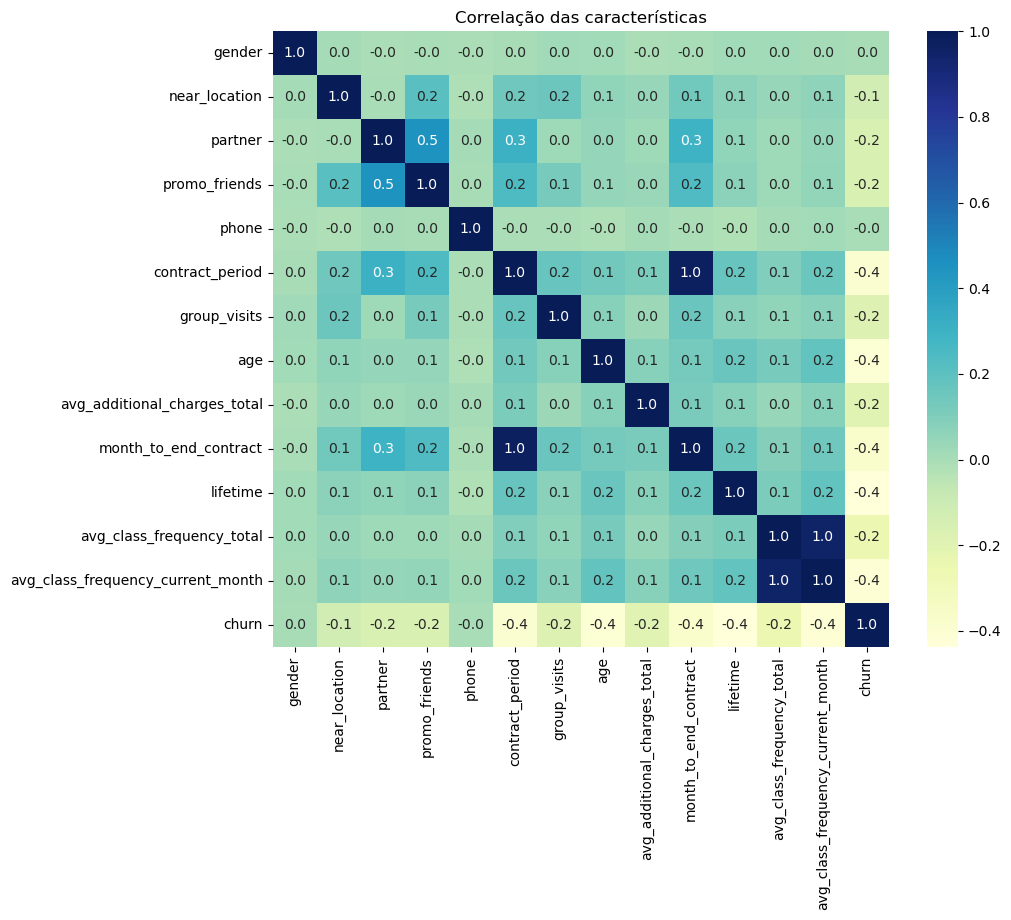

In [9]:
cm = gym.corr()
plt.figure(figsize=[10,8])
plt.title('Correlação das características')

sns.heatmap(cm, annot=True, square=True, fmt='.1f', cmap="YlGnBu")

O mapa de calor nos mostra que existe que existe uma correlação relativamente baixa entre os dados. Apesar disso, podemos perceber que e o tempo do contrato, idade e a média de frequência das aulas e o cancelamento estão relacionados, sendo pontos importantes a serem considerados.

Por outro lado, podemos avaliar que clientes que se assosociaram através da promoção 'indique um amigo' e aqueles que trabalham em empresas parceiras da academia, tendem a cancelar menos.

### <b> Passo 3. Construa um modelo para predizer a rotatividade de clientes </b>
Construa um modelo de classificação binária para clientes onde a variável objetivo é a saída de usuários do próximo mês.

#### Divida os dados de treinamento e validação em dois conjuntos usando a função train_test_split().

In [10]:
#selecionando colunas que se destacaram, baseadas nas análises anteriores

X = gym.drop('churn', axis = 1)
y = gym['churn']

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [12]:
scaler = StandardScaler()
scaler.fit(X_train) 
X_train_st = scaler.transform(X_train) 
X_test_st = scaler.transform(X_test)

#### Treine o modelo no conjunto com dois métodos:
- regressão logística

In [13]:
models = LogisticRegression()

models.fit(X_train, y_train)

churn_proba = models.predict_proba(X_test)[:,1]

predicitions = models.predict(X_test)

print('Acurácia: {:.2f}'.format(accuracy_score(y_test, predicitions)))
print('Precisão: {:.2f}'.format(precision_score(y_test, predicitions)))
print('Sensibilidade: {:.2f}'.format(recall_score(y_test, predicitions)))
print('F1: {:.2f}'.format(f1_score(y_test, predicitions)))
print('ROC_AUC:: {:.2f}'.format(roc_auc_score(y_test, churn_proba)))


Acurácia: 0.91
Precisão: 0.82
Sensibilidade: 0.80
F1: 0.81
ROC_AUC:: 0.96


c:\Users\KamilaTiemi\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


- floresta aleatória

In [14]:
rf_models = RandomForestClassifier(n_estimators=100, random_state=0)
rf_models.fit(X_train, y_train)
rf_predict = rf_models.predict(X_test_st)
rf_proba = rf_models.predict_proba(X_test_st)[:,1]

print('Acurácia: {:.2f}'.format(accuracy_score(y_test, rf_predict)))
print('Precisão: {:.2f}'.format(precision_score(y_test, rf_predict)))
print('Sensibilidade: {:.2f}'.format(recall_score(y_test, rf_predict)))
print('F1: {:.2f}'.format(f1_score(y_test, rf_predict)))
print('ROC_AUC:: {:.2f}'.format(roc_auc_score(y_test, churn_proba)))

Acurácia: 0.26
Precisão: 0.25
Sensibilidade: 1.00
F1: 0.40
ROC_AUC:: 0.96


c:\Users\KamilaTiemi\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\KamilaTiemi\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


#### Avalie acurácia, precisão e sensibilidade para ambos os modelos usando dados de validação. Use-os para comparar os modelos. Qual modelo rendeu melhores resultados?

Olhando as métricas acima, podemos analisar que a regressão logística apresentou resultados melhores que os de flores aleatória. A sensibilidade do flores aleatória foi 1, enquanto a de regressão logística foi 0,81.

### <b>Passo 4. Crie agrupamentos de clientes</b>
Defina ao lado colunas com dados sobre rotatividade e identifique agrupamentos do objeto (cliente):
- Padronize os dados.

In [15]:
#separando churn
iso_churn = gym.drop('churn', axis = 1)
iso_churn.head(2)

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244


In [16]:
sc = StandardScaler()
x_sc = sc.fit_transform(iso_churn)


- Use a função linkage() para construir a matriz das distâncias baseada na matriz de características padronizada e construa um dendrograma. Perceba: renderizar o dendrograma pode demorar um tempo! Use o gráfico resultante para estimar o número de agrupamentos que você pode destacar.

In [17]:
linked = linkage(x_sc, method = 'ward') 

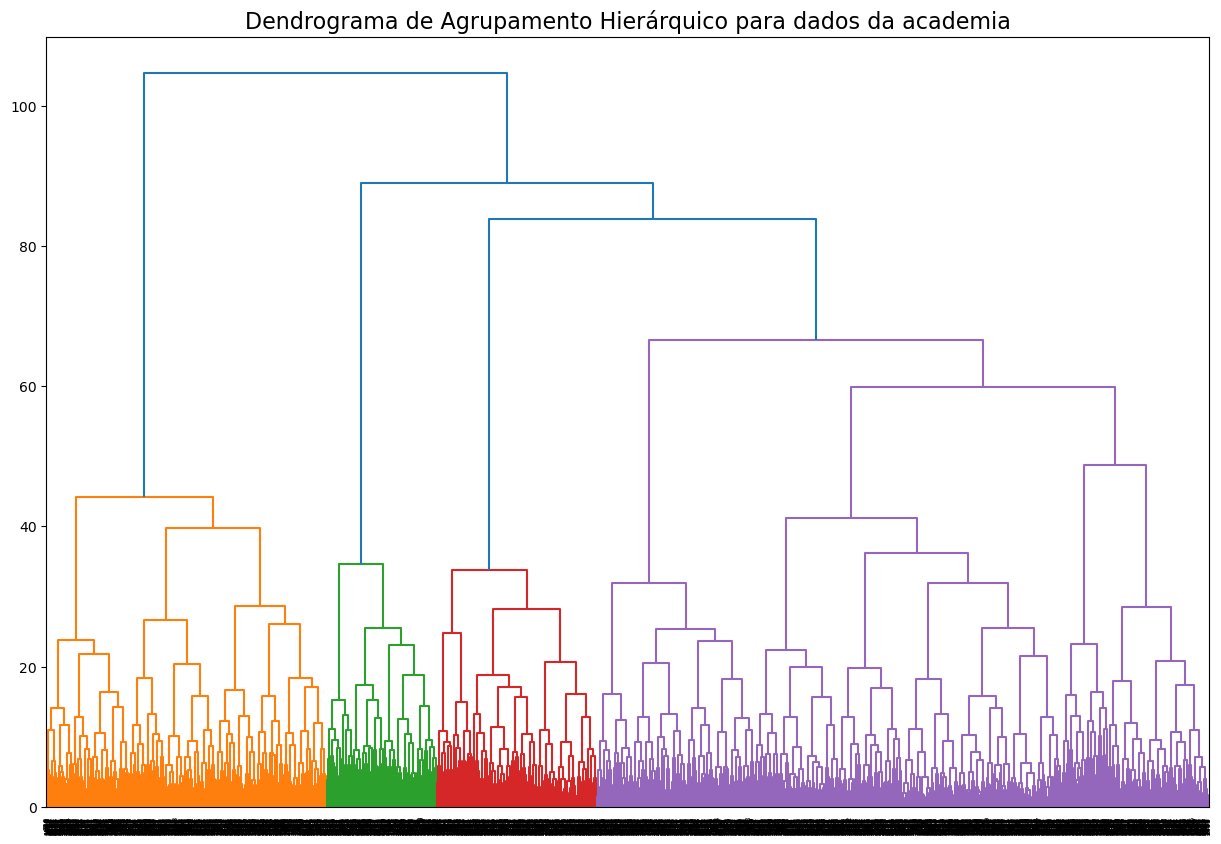

In [18]:
plt.figure(figsize=(15, 10))
dendrogram(linked, orientation='top')
plt.title('Dendrograma de Agrupamento Hierárquico para dados da academia', fontsize=16)
plt.show()

O dendograma foi dividido entre 4 grupos, sendo o 4º o maior entre eles

#### Treine o modelo de agrupamento com o algoritmo K-means e preveja agrupamentos de clientes. (Deixe que o número de agrupamentos seja n=5,para que seja fácil comparar seus resultados com os de outros estudantes. No entanto, na vida real, ninguém vai te dar essas dicas, para que você tenha que decidir baseados nos gráficos das etapas anteriores.)

In [19]:
km = KMeans(n_clusters=5, random_state=0)
labels = km.fit_predict(x_sc)

c:\Users\KamilaTiemi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [20]:
iso_churn['cluster_km'] = labels

#### Olhe para os valores médios das características para agrupamentos. Nada chama a sua atenção?

In [21]:
mean_iso = iso_churn.groupby(['cluster_km']).mean().reset_index()

mean_iso

,cluster_km,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
0,0,0.495413,0.000000,0.466055,0.077064,0.915596,2.227523,0.214679,28.484404,133.862709,2.091743,2.788991,1.656393,1.465891
1,1,0.585938,0.971354,0.260417,0.092448,0.903646,2.813802,0.477865,30.144531,162.010722,2.589844,5.132812,2.883403,2.884764
2,2,0.484424,0.998442,0.822430,1.000000,0.900312,3.155763,0.454829,29.218069,141.203442,2.919003,3.705607,1.734352,1.627826
3,3,0.500534,0.945571,0.741729,0.486660,0.899680,11.871932,0.552828,29.933831,164.763165,10.865528,4.695838,2.001331,1.992684
4,4,0.488267,1.000000,0.243682,0.020758,0.902527,1.985560,0.320397,28.209386,131.191160,1.901625,2.398917,1.272734,1.030315


In [22]:
silhouette_score(x_sc, labels)

print('Silhouette_score: {:.2f}'.format(silhouette_score(x_sc, labels)))

Silhouette_score: 0.13


O resultado acabou sendo relativamente baixo, demonstrando pouca similaridade entre os agrupamentos.

#### Faça distribuições de características para os agrupamentos. Você notou alguma coisa?

c:\Users\KamilaTiemi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\KamilaTiemi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\KamilaTiemi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\KamilaTiemi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: 

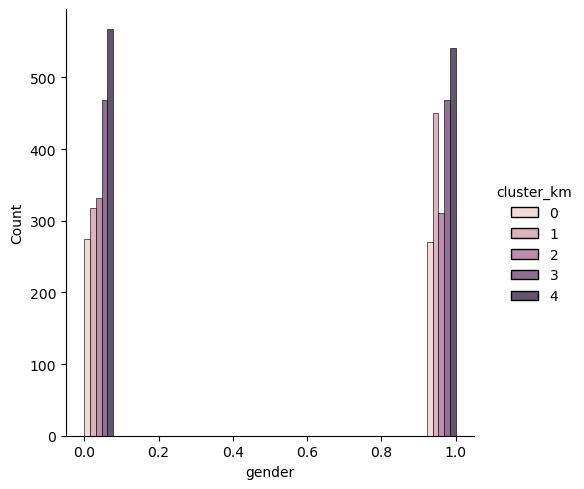

c:\Users\KamilaTiemi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\KamilaTiemi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\KamilaTiemi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\KamilaTiemi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: 

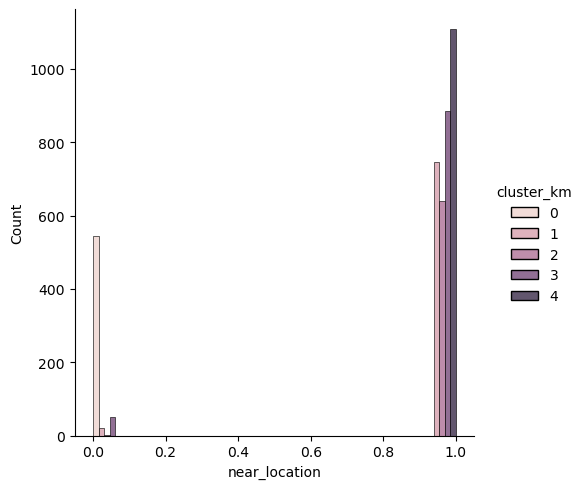

c:\Users\KamilaTiemi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\KamilaTiemi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\KamilaTiemi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\KamilaTiemi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: 

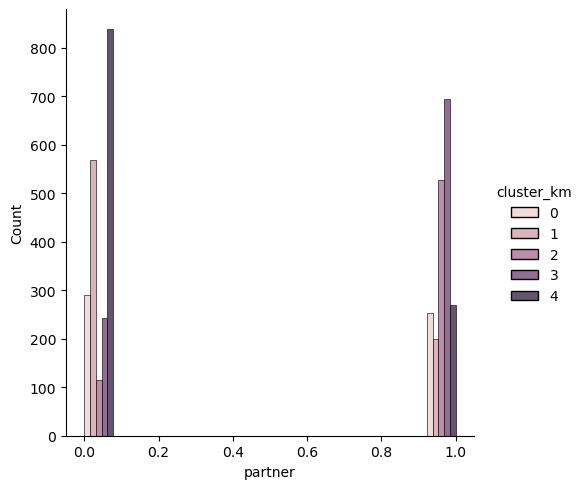

c:\Users\KamilaTiemi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\KamilaTiemi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\KamilaTiemi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\KamilaTiemi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: 

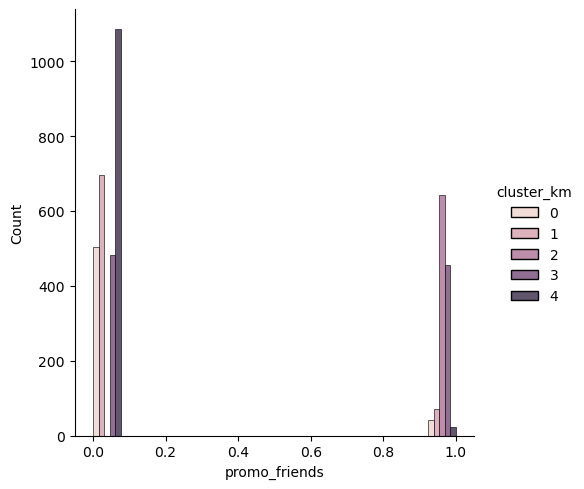

c:\Users\KamilaTiemi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\KamilaTiemi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\KamilaTiemi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\KamilaTiemi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: 

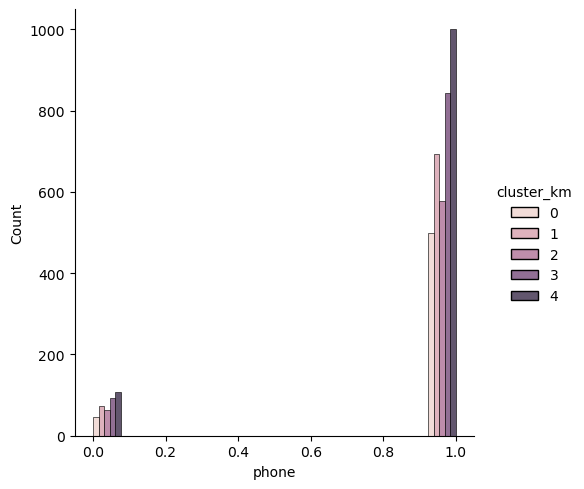

c:\Users\KamilaTiemi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\KamilaTiemi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\KamilaTiemi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\KamilaTiemi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: 

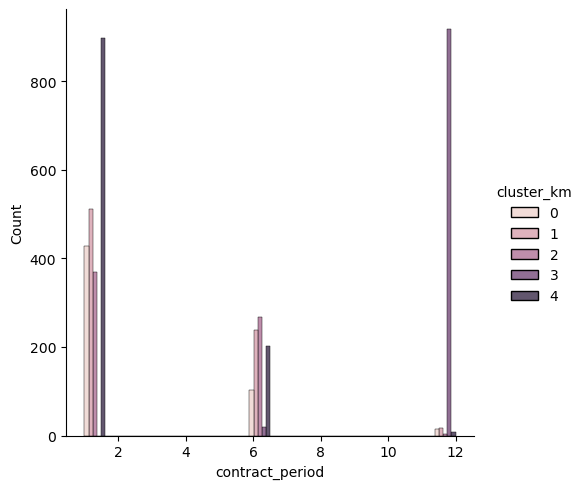

c:\Users\KamilaTiemi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\KamilaTiemi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\KamilaTiemi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\KamilaTiemi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: 

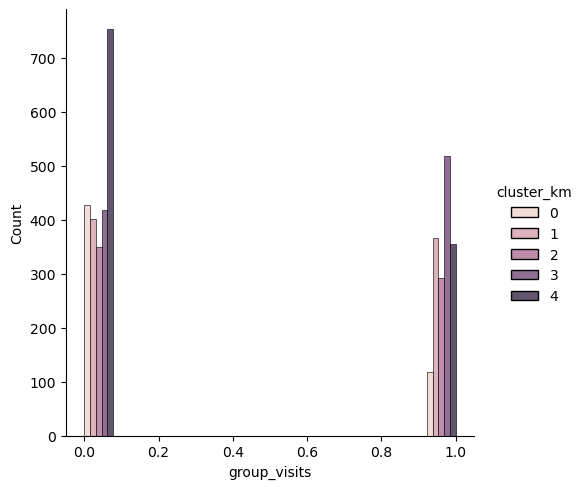

c:\Users\KamilaTiemi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\KamilaTiemi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\KamilaTiemi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\KamilaTiemi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: 

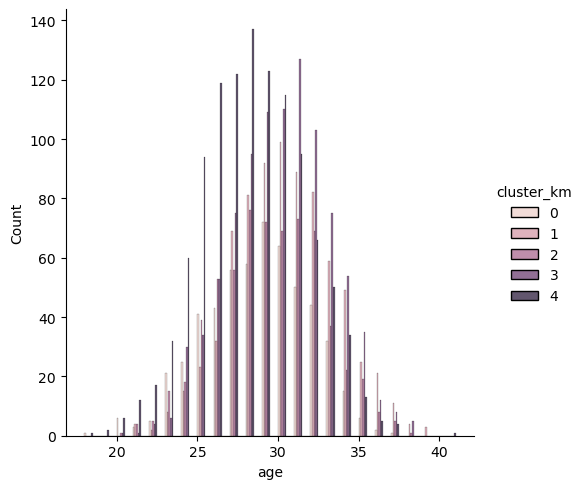

c:\Users\KamilaTiemi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\KamilaTiemi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\KamilaTiemi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\KamilaTiemi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: 

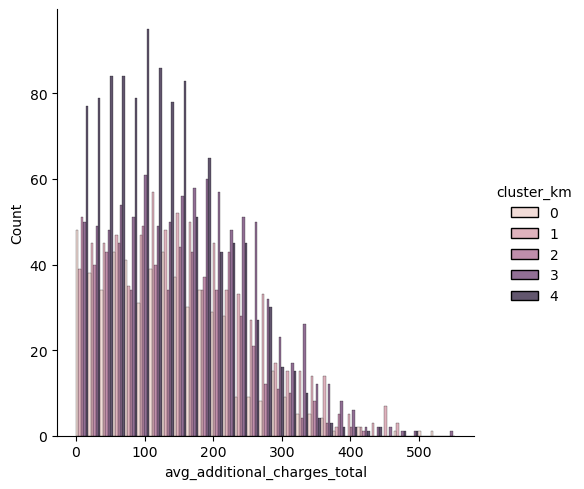

c:\Users\KamilaTiemi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\KamilaTiemi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\KamilaTiemi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\KamilaTiemi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: 

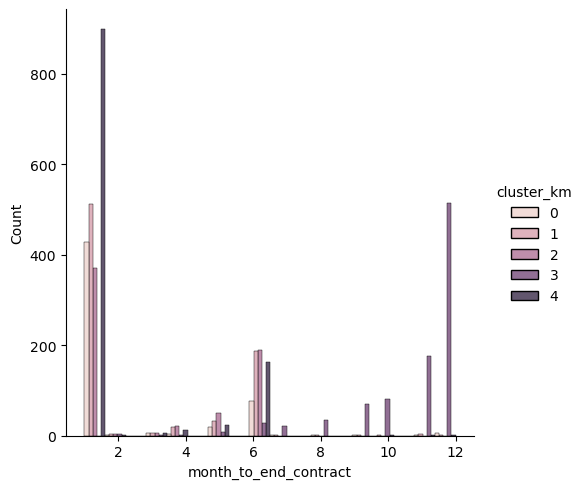

c:\Users\KamilaTiemi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\KamilaTiemi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\KamilaTiemi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\KamilaTiemi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: 

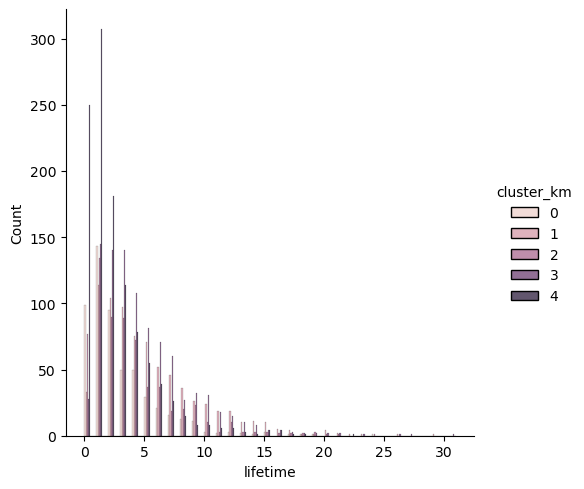

c:\Users\KamilaTiemi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\KamilaTiemi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\KamilaTiemi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\KamilaTiemi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: 

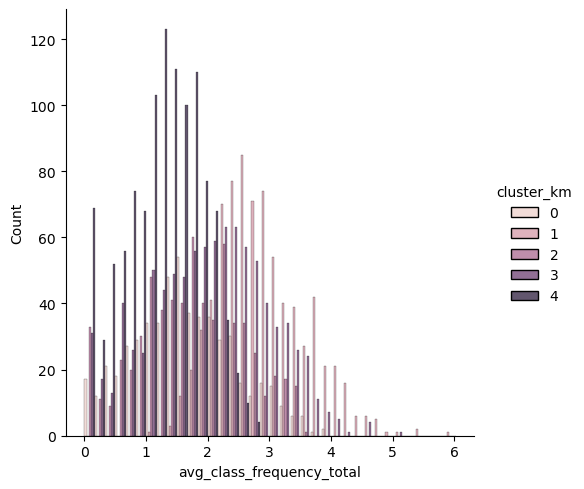

c:\Users\KamilaTiemi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\KamilaTiemi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\KamilaTiemi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\KamilaTiemi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: 

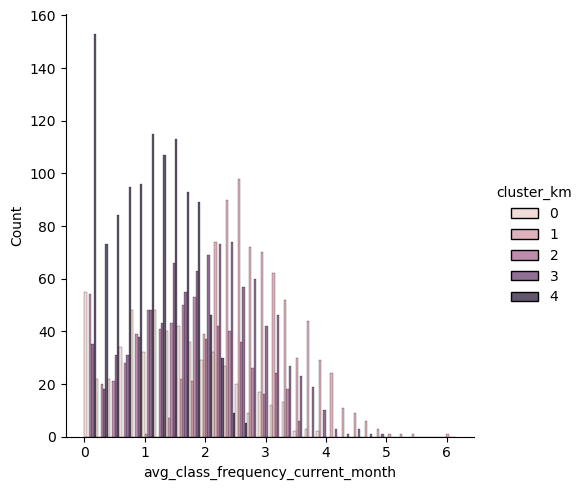

c:\Users\KamilaTiemi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\KamilaTiemi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\KamilaTiemi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\KamilaTiemi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: 

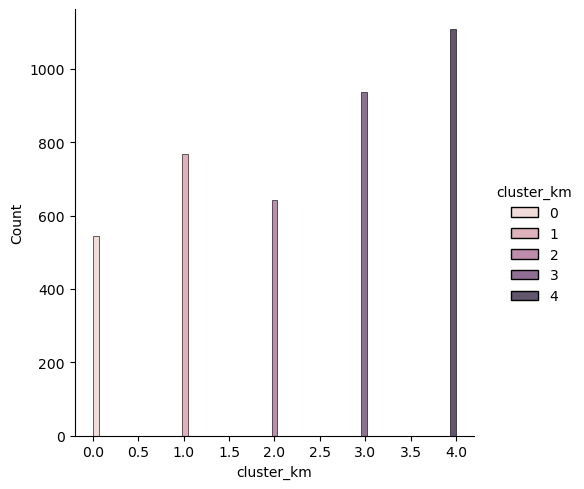

In [23]:
for column in iso_churn:
    sns.displot(iso_churn, x=column, hue='cluster_km',multiple="dodge")
    plt.show()

Não ter vindo através de uma parceria da empresa parece definir o cluster 0, enquanto o contrário acontece para o cluster 2. O cluster 3 também tem menos chances de ter vindo através de um amigo.
O cluster 0 parece ser definido por não fornecer número de telefone. O cluster 2 parece ser definido por ter 12 meses de contrato, enquanto o cluster 0 tem, majoritariamente, 1 mes de contrato.
A idade tem uma distribuição normal através dos grupos, com o cluster 0 contendo os mais jovens.

Nada é muito aparente nas cobranças adicionais, o mês para encerrar o contrato é mais curto no cluster 0 e maior no cluster 4. A média das aulas e frenquencia parecem bem befinidas e separadas para cada grupo.

#### Calcule a taxa de rotatividade para cada agrupamento (use o método groupby()). Eles diferem em termos de taxa de rotatividade? Quais agrupamentos são propensos a sair, e quais são leais?

In [24]:
data_merged = pd.merge(iso_churn, gym[['age', 'avg_additional_charges_total', 'churn']],on=['age', 'avg_additional_charges_total'], how='left')
data_merged.head()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,cluster_km,churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,2,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,3,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,4,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,3,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,2,0


In [25]:
churn_rate_by_cluster = data_merged.groupby('cluster_km')['churn'].mean()

print(churn_rate_by_cluster)

cluster_km
0    0.449541
1    0.069010
2    0.247664
3    0.022412
4    0.526173
Name: churn, dtype: float64


O cluster que tem mais propensão a sair é o 0, seguido pelo 4 e então o 3. O cluster que é provavel a ser leal é o 1, seguido pelo 2.

### Passo 5. Chegue a conclusões e faça recomendações básicas sobre trabalhar com clientes

Com base nos dados que analisamos, é possível analisar certos fatores que poderão dizer se o cliente irá ou não cancelar e são eles: 
 - se ele entrou ou não por um programa de parceiros,
 - a duração do contrato
 - se ele frenquentou as aulas ou não.

 Se o cliente veio através de um programa de parceiros, é mais provável que ele paermaneça, o que pode significar que a academia deveria focar em mais formar mais parceiras ou abordar estratégias diferentes para aqueles clientes que não vieram através do programa de parceira. 

 Um contrato longo também é uma maneira de garantir que o cliente não irá cancelar, talvez promover ações de desconto progressivo em contratos longos ou vinculados a aulas que mais chamam atenção dos clientes.

A presença nas aulas também garante que o aluno não vai cancelar, o que pode ser um forte indício de que é necessário melhorar a qualidade das aulas ou criar ações de incentivo para os alunos frequentarem mais vezes.